# 🇧🇷 Electricity Demand Forecasting for Brazil's National Interconnected System (SIN)

This notebook implements **N-BEATS (Neural Basis Expansion Analysis for Time Series)** models to forecast electricity demand across Brazil's four major interconnected regions:

- **N** - North Region
- **NE** - Northeast Region  
- **S** - South Region
- **SE** - Southeast Region

## Project Overview

We develop forecasting models for two prediction horizons:
- **24-hour ahead** forecasting (short-term planning)
- **168-hour ahead** forecasting (weekly planning)

### Workflow
1. Data Loading & Preprocessing
2. Exploratory Data Analysis (EDA)
3. Seasonality Analysis (ACF/PACF)
4. Model Training with N-BEATS
5. Model Evaluation & Selection
6. Model Persistence & Inference

---
## 1. Setup and Import Libraries

Import all required libraries for data manipulation, visualization, deep learning, and model persistence.

In [3]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

# Deep learning and forecasting
import torch
import neuralforecast
from neuralforecast.losses.pytorch import MAE
from neuralforecast.models import NBEATS

# Time series analysis
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot

# Model persistence
import joblib

# Dataset loading
from datasets import load_dataset

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

e:\conda_envs\forecast\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.2.2+cu121
CUDA available: True


---
## 2. Load Dataset from HuggingFace

We use the **Hourly Electricity Demand Brazil Dataset** from HuggingFace, which contains hourly electricity load data for Brazil's four interconnected regions.

In [4]:
# Load dataset from HuggingFace
dataset = load_dataset("SamuelM0422/Hourly-Electricity-Demand-Brazil-Dataset")
print(dataset)

# Convert to pandas DataFrame
df = dataset['train'].to_pandas()
df.head()

DatasetDict({
    train: Dataset({
        features: ['id_subsistema', 'nom_subsistema', 'din_instante', 'val_cargaenergiahomwmed'],
        num_rows: 185280
    })
})


,id_subsistema,nom_subsistema,din_instante,val_cargaenergiahomwmed
0,N,NORTE,2020-01-01 00:00:00,4889.1460
1,NE,NORDESTE,2020-01-01 00:00:00,9617.9750
2,S,SUL,2020-01-01 00:00:00,10013.7420
3,SE,SUDESTE,2020-01-01 00:00:00,33108.8615
4,N,NORTE,2020-01-01 01:00:00,4953.3150


---
## 3. Data Preprocessing and Cleaning

Rename columns for clarity and explore the dataset structure.

In [5]:
# Rename columns for clarity
df.columns = ['region_id', 'region_name', 'date', 'total_load']

# Display basic info
print("=" * 50)
print("DATASET INFORMATION")
print("=" * 50)
df.info()

print(f"\nDataset Shape: {df.shape}")
print(f"Duplicated Rows: {df.duplicated().sum()}")

# Get unique regions
regions = df['region_id'].unique()
print(f"\nRegions: {regions}")

# Row counts per region
print("\nRows per Region:")
print(df['region_id'].value_counts())

df.head()

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185280 entries, 0 to 185279
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   region_id    185280 non-null  object        
 1   region_name  185280 non-null  object        
 2   date         185280 non-null  datetime64[ns]
 3   total_load   185280 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.7+ MB

Dataset Shape: (185280, 4)
Duplicated Rows: 0

Regions: ['N' 'NE' 'S' 'SE']

Rows per Region:
region_id
N     46320
NE    46320
S     46320
SE    46320
Name: count, dtype: int64


,region_id,region_name,date,total_load
0,N,NORTE,2020-01-01 00:00:00,4889.1460
1,NE,NORDESTE,2020-01-01 00:00:00,9617.9750
2,S,SUL,2020-01-01 00:00:00,10013.7420
3,SE,SUDESTE,2020-01-01 00:00:00,33108.8615
4,N,NORTE,2020-01-01 01:00:00,4953.3150


---
## 4. Exploratory Data Analysis

### 4.1 Regional Distribution Analysis
Visualize the distribution of electricity load across different regions using boxplots to identify outliers and compare regional demand patterns.

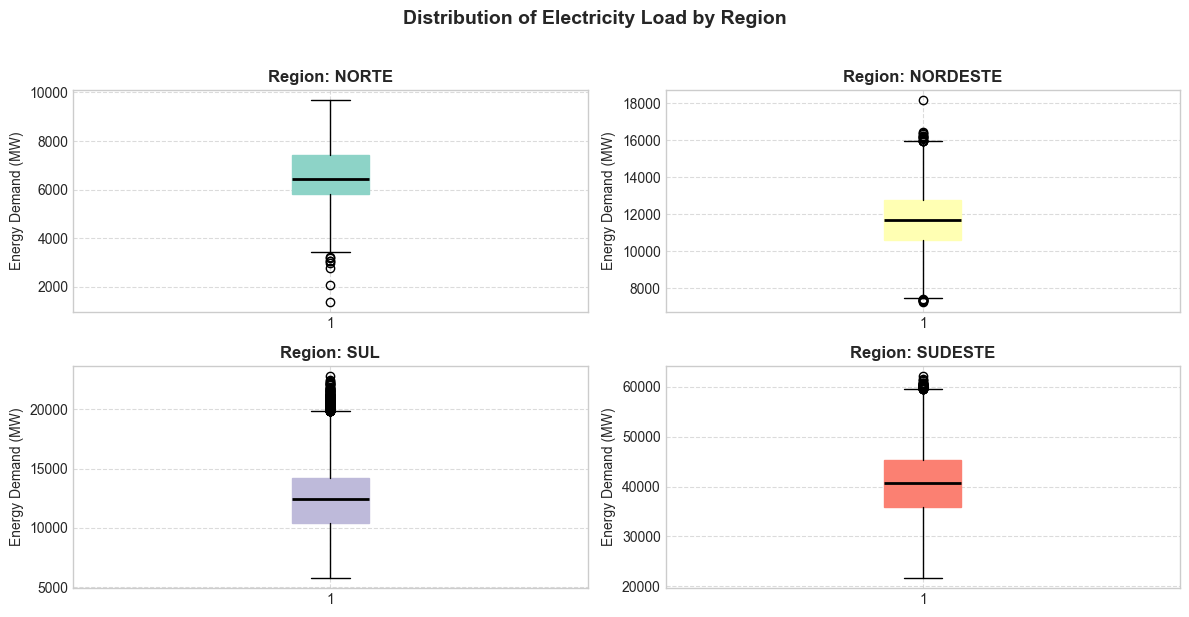

In [6]:
# Boxplot: Distribution of electricity load by region
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
colors = sns.color_palette('Set3')
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = df[df['region_id'] == region]
    axes[i].boxplot(
        region_df['total_load'], 
        patch_artist=True, 
        boxprops=dict(facecolor=colors[i], color=colors[i]),
        medianprops=dict(color='black', linewidth=2)
    )
    axes[i].set_title(f'Region: {region_df["region_name"].iloc[0]}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Energy Demand (MW)')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Distribution of Electricity Load by Region', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/eda/boxplot_by_region.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 Daily Demand Trends
Resample the hourly data to daily frequency and visualize how electricity demand varies over time for each region.

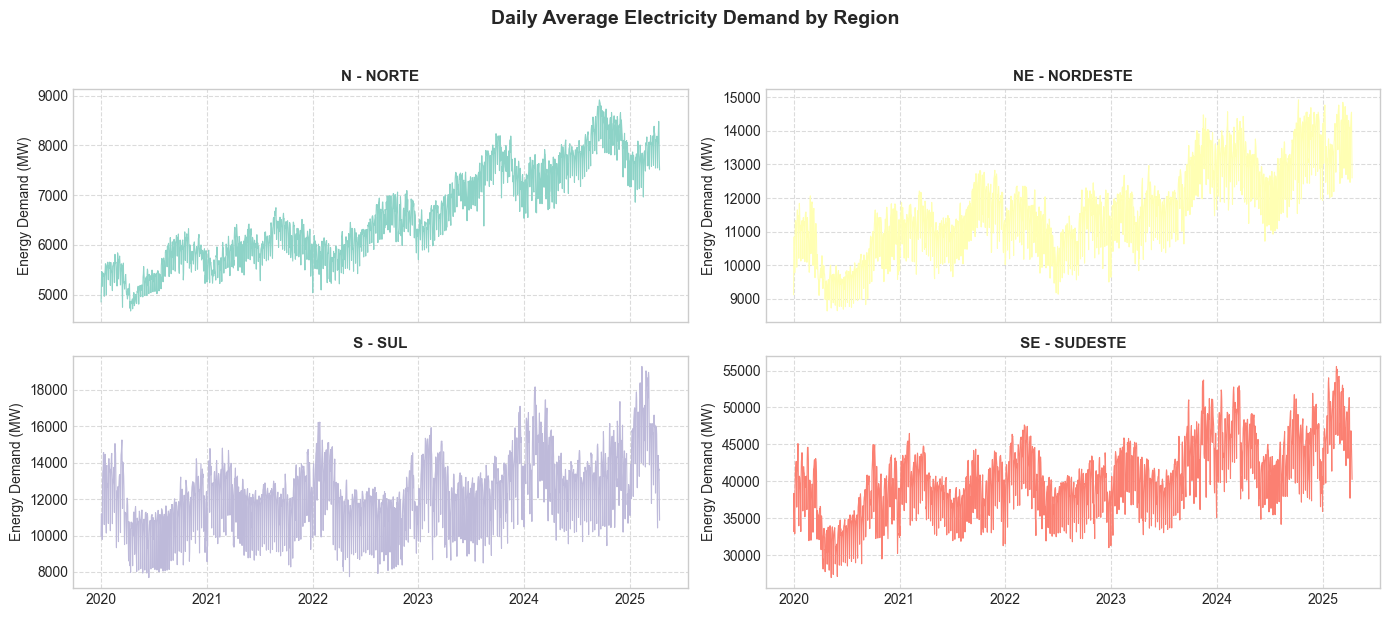

In [7]:
# Resample to daily frequency
daily_df = df.groupby(['region_id', 'region_name']).resample("D", on="date").mean(numeric_only=True).reset_index()

# Plot daily demand trends
fig, axes = plt.subplots(2, 2, figsize=(14, 6), sharex=True)
colors = sns.color_palette('Set3')
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = daily_df[daily_df['region_id'] == region]
    axes[i].plot(region_df['date'], region_df['total_load'], color=colors[i], linewidth=0.8)
    axes[i].set_title(f'{region} - {region_df["region_name"].iloc[0]}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Energy Demand (MW)')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Daily Average Electricity Demand by Region', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/eda/daily_demand_by_region.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.3 Yearly Trend Analysis
Aggregate data by year to identify long-term trends in electricity demand. This helps understand overall growth patterns in energy consumption.

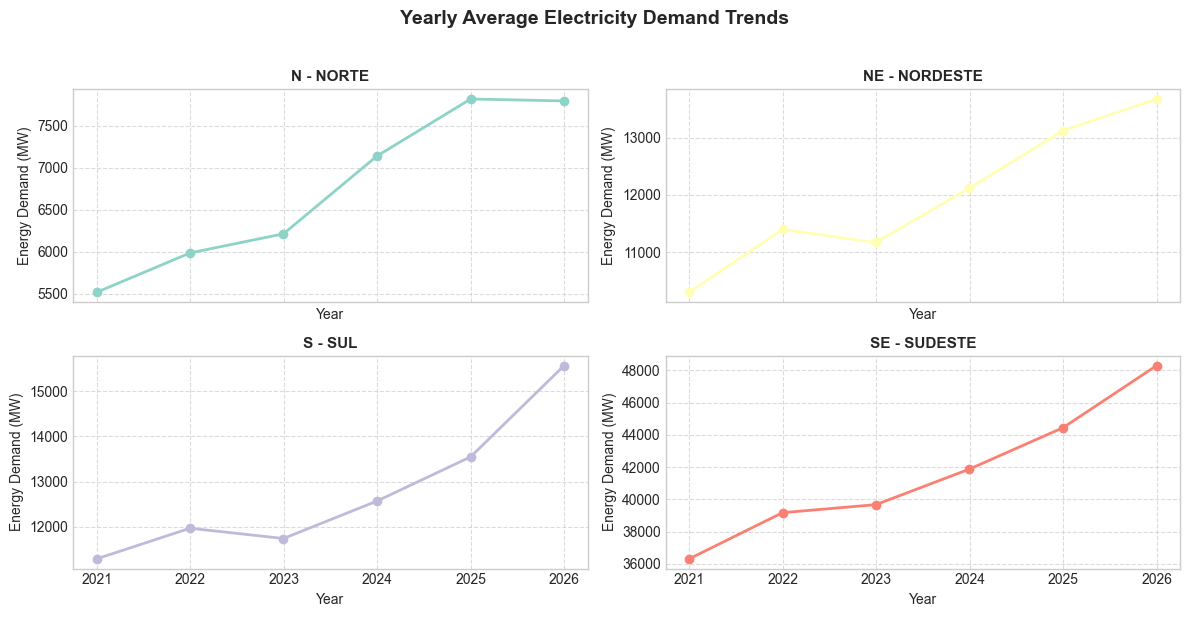

In [8]:
# Resample to yearly frequency
years_df = df.groupby(['region_id', 'region_name']).resample("Y", on="date").mean(numeric_only=True).reset_index()

# Plot yearly trends
fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)
colors = sns.color_palette('Set3')
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = years_df[years_df['region_id'] == region]
    axes[i].plot(region_df['date'], region_df['total_load'], color=colors[i], marker='o', linewidth=2, markersize=6)
    axes[i].set_title(f'{region} - {region_df["region_name"].iloc[0]}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Energy Demand (MW)')
    axes[i].grid(True, linestyle='--', alpha=0.7)

plt.suptitle('Yearly Average Electricity Demand Trends', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/eda/yearly_demand_by_region.png', dpi=300, bbox_inches='tight')
plt.show()


 > Key Observation: There is a visible upward trend in electricity demand over the years across all regions.

---
## 5. Seasonality Analysis

### 5.1 ACF and PACF Analysis
The **Autocorrelation Function (ACF)** and **Partial Autocorrelation Function (PACF)** help identify:
- Seasonal patterns in the data
- Appropriate lag values for time series modeling
- The memory structure of the time series

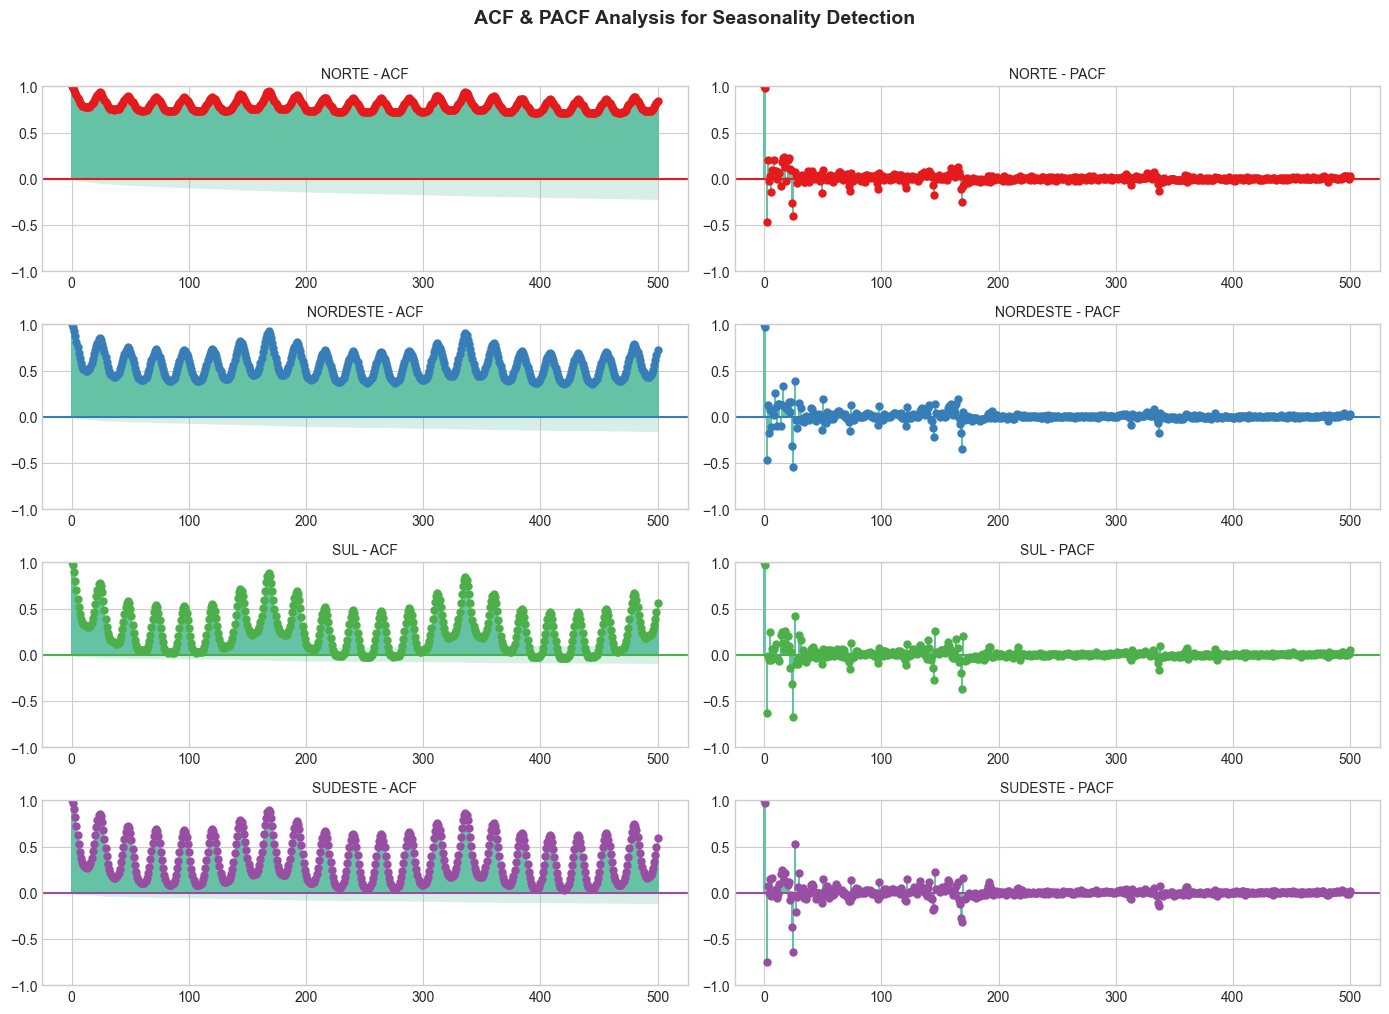

In [9]:
# ACF and PACF Analysis for all regions
colors = sns.color_palette('Set1')
fig, axes = plt.subplots(4, 2, figsize=(14, 10))

for i, region in enumerate(regions):
    region_df = df[df['region_id'] == region]
    plot_acf(region_df['total_load'].to_list(), lags=500, ax=axes[i][0], color=colors[i])
    plot_pacf(region_df['total_load'].to_list(), lags=500, ax=axes[i][1], color=colors[i])
    axes[i][0].set_title(f'{region_df["region_name"].iloc[0]} - ACF', fontsize=10)
    axes[i][1].set_title(f'{region_df["region_name"].iloc[0]} - PACF', fontsize=10)

fig.suptitle("ACF & PACF Analysis for Seasonality Detection", fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.savefig('../images/eda/acf_pacf_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


> Key Observations:
   - Strong daily seasonality (24-hour cycles)
   - Weekly patterns visible at 168-hour lags
   - Slow decay in ACF indicates trend component
---

### 5.2 Autocorrelation Plot
A simplified view of autocorrelation to confirm seasonal patterns.

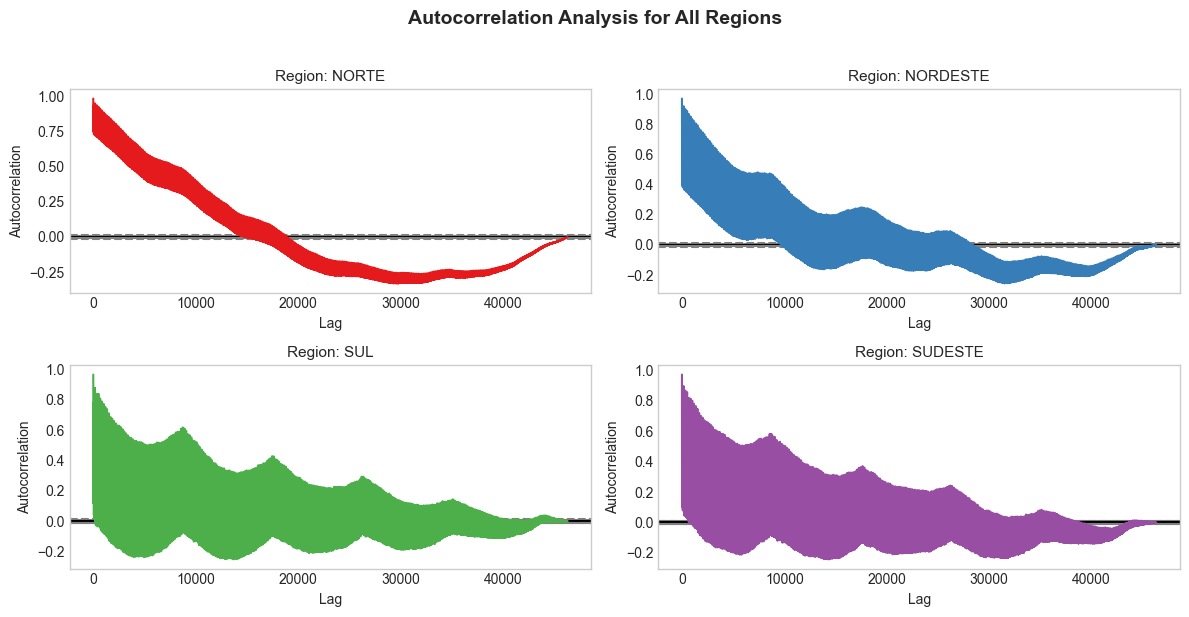

In [10]:
# Autocorrelation plots for all regions
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

for i, region in enumerate(regions):
    region_df = df[df['region_id'] == region]
    autocorrelation_plot(region_df['total_load'], ax=axes[i], color=colors[i])
    axes[i].set_title(f"Region: {region_df['region_name'].iloc[0]}", fontsize=11)

fig.suptitle("Autocorrelation Analysis for All Regions", fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/eda/autocorrelation_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

---
## 6. Helper Functions

Define utility functions for data splitting, model training, and evaluation.

In [11]:
def train_test_split(df, horizon):
    """
    Split time series data into training and test sets.
    
    Args:
        df: DataFrame with time series data
        horizon: Number of time steps to use as test set
    
    Returns:
        train_df, test_df
    """
    df = df.sort_values('date')
    train_df = df.iloc[:-horizon]
    test_df = df.iloc[-horizon:].copy()
    return train_df, test_df


def calculate_mae(evaluation_df):
    """
    Calculate MAE for both model variants.
    
    Args:
        evaluation_df: DataFrame with actual and predicted values
    
    Returns:
        MAE for model 1 and model 2
    """
    mae_func = MAE()
    y = torch.tensor(evaluation_df['total_load'].to_numpy())
    y_hat_1 = torch.tensor(evaluation_df['NBEATS'].to_numpy())
    y_hat_2 = torch.tensor(evaluation_df['NBEATS1'].to_numpy())
    return mae_func(y=y, y_hat=y_hat_1), mae_func(y=y, y_hat=y_hat_2)


def plot_forecast(data, region, horizon, model_name='NBEATS'):
    """
    Plot forecast vs actual values.
    
    Args:
        data: DataFrame with actual and predicted values
        region: Region identifier
        horizon: Forecast horizon
        model_name: Name of the model column
    """
    plt.figure(figsize=(12, 4))
    plt.plot(data['date'], data['total_load'], color='red', label='Actual', linewidth=2)
    plt.plot(data['date'], data[model_name], color='green', label='Forecast', linewidth=2, linestyle='--')
    plt.title(f"N-BEATS Forecast vs Actual ({horizon}h) - Region {region}", fontsize=12, fontweight='bold')
    plt.xlabel("DateTime")
    plt.ylabel("Electricity Load (MW)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=30)
    plt.tight_layout()
    return plt


print("Helper functions defined successfully")

Helper functions defined successfully


---
## 7. Load Optimized Hyperparameters

Load pre-tuned hyperparameters from Optuna optimization studies. These parameters were optimized separately to find the best configuration for each region.

In [12]:
# Load optimized hyperparameters from JSON files
try:
    with open('../model_train/optuna_best_params_24.json', 'r') as f:
        best_params_24h = json.load(f)
    print("Loaded 24h hyperparameters:")
    print(json.dumps(best_params_24h, indent=2))
except FileNotFoundError:
    print("24h params file not found - will use default parameters")
    best_params_24h = {}

print("\n" + "="*50 + "\n")

try:
    with open('../model_train/optuna_best_values_24.json', 'r') as f:
        best_values_24h = json.load(f)
    print("Loaded 24h best MAE values:")
    print(json.dumps(best_values_24h, indent=2))
except FileNotFoundError:
    print("24h values file not found")
    best_values_24h = {}

Loaded 24h hyperparameters:
{
  "N": {
    "input_size": 37,
    "num_blocks_per_stack": 3,
    "num_stacks": 3,
    "hidden_units": [
      512,
      512
    ],
    "n_harmonics": 2,
    "n_polynomials": 1,
    "learning_rate": 0.0009569341835829512
  },
  "NE": {
    "input_size": 77,
    "num_blocks_per_stack": 3,
    "num_stacks": 3,
    "hidden_units": [
      256,
      256
    ],
    "n_harmonics": 2,
    "n_polynomials": 2,
    "learning_rate": 0.002415628360583949
  },
  "S": {
    "input_size": 105,
    "num_blocks_per_stack": 2,
    "num_stacks": 2,
    "hidden_units": [
      256,
      256
    ],
    "n_harmonics": 3,
    "n_polynomials": 1,
    "learning_rate": 0.0007497743051723375
  },
  "SE": {
    "input_size": 84,
    "num_blocks_per_stack": 2,
    "num_stacks": 3,
    "hidden_units": [
      1024,
      1024
    ],
    "n_harmonics": 1,
    "n_polynomials": 2,
    "learning_rate": 0.0004905927666685822
  }
}


Loaded 24h best MAE values:
{
  "N": 68.6670701518229,


---
## 8. Model Training Functions

Define functions for training N-BEATS models with both default and optimized hyperparameters.

In [13]:
def train_nbeats(train_df, region, horizon, best_params):
    """
    Train N-BEATS models for a given region.
    
    Args:
        train_df: Training DataFrame
        region: Region identifier
        horizon: Forecast horizon
        best_params: Dictionary of optimized parameters per region
    
    Returns:
        Trained NeuralForecast model
    """
    accelerator = "gpu" if torch.cuda.is_available() else "cpu"
    print(f"Using accelerator: {accelerator}")
    
    # Model 1: Default N-BEATS configuration
    model_default = NBEATS(
        h=horizon,
        input_size=horizon * 2,
        n_harmonics=2,
        n_polynomials=2,
        mlp_units=[[512, 512], [512, 512], [512, 512]],
        max_steps=2500,
        n_blocks=[2, 2, 1],
        valid_loss=MAE(),
        shared_weights=True,
        batch_size=256,
        start_padding_enabled=True,
        accelerator=accelerator
    )
    
    # Model 2: Optimized N-BEATS with Optuna parameters
    if region in best_params:
        params = best_params[region]
        n_blocks_list = [params['num_blocks_per_stack']] * 3
        mlp_units_list = [params['hidden_units']] * 3
        
        model_optimized = NBEATS(
            h=horizon,
            input_size=params['input_size'],
            stack_types=['seasonality', 'trend', 'identity'],
            n_blocks=n_blocks_list,
            mlp_units=mlp_units_list,
            n_harmonics=params['n_harmonics'],
            n_polynomials=params['n_polynomials'],
            learning_rate=params['learning_rate'],
            loss=MAE(),
            valid_loss=MAE(),
            max_steps=600,
            scaler_type='robust',
            batch_size=128,
            shared_weights=True,
            start_padding_enabled=True,
            random_seed=1,
            num_workers_loader=0,
            accelerator=accelerator
        )
    else:
        # Fallback to default if no optimized params
        model_optimized = NBEATS(
            h=horizon,
            input_size=horizon * 3,
            n_harmonics=2,
            n_polynomials=2,
            mlp_units=[[256, 256], [256, 256], [256, 256]],
            max_steps=600,
            valid_loss=MAE(),
            batch_size=128,
            accelerator=accelerator
        )
    
    # Create NeuralForecast with both models
    nf = neuralforecast.NeuralForecast(
        models=[model_default, model_optimized],
        freq='h'
    )
    
    # Train models
    nf.fit(
        train_df, 
        verbose=True, 
        id_col='region_id',
        time_col='date', 
        target_col='total_load',
        val_size=horizon
    )
    
    return nf


def train_final_model(best_params, region_df):
    """
    Train final model on full data with best hyperparameters.
    
    Args:
        best_params: Model hyperparameters
        region_df: Full region DataFrame
    
    Returns:
        Trained NeuralForecast model
    """
    model = NBEATS(**best_params)
    nf = neuralforecast.NeuralForecast(models=[model], freq='h')
    nf.fit(
        df=region_df, 
        verbose=True, 
        id_col='region_id',
        time_col='date', 
        target_col='total_load',
        val_size=0  # Train on all data for final model
    )
    return nf


print("Training functions defined")

Training functions defined


---
## 9. Train N-BEATS Models - 24-Hour Horizon

Train models for short-term (24-hour) electricity demand forecasting for all regions.

In [14]:
# 24-Hour Horizon Training
HORIZON_24 = 24
models_24h = {}
forecasts_24h = {}

print("=" * 60)
print("TRAINING N-BEATS MODELS - 24-HOUR HORIZON")
print("=" * 60)

for region in regions:
    print(f"\n{'='*40}")
    print(f"Training models for Region: {region}")
    print(f"{'='*40}")
    
    # Prepare data
    region_df = df[df['region_id'] == region].drop(['region_name'], axis=1)
    train_df, test_df = train_test_split(region_df, HORIZON_24)
    
    # Train models
    model = train_nbeats(train_df, region, HORIZON_24, best_params_24h)
    
    # Generate predictions
    preds = model.predict().reset_index()
    
    # Merge predictions with test data
    merged = pd.merge(test_df, preds, on=['region_id', 'date'], how='left')
    
    # Store results
    models_24h[region] = model
    forecasts_24h[region] = merged
    
    print(f"Completed training for region {region}")

print("\n" + "=" * 60)
print("ALL 24-HOUR MODELS TRAINED SUCCESSFULLY")
print("=" * 60)

Seed set to 1
Seed set to 1


TRAINING N-BEATS MODELS - 24-HOUR HORIZON

Training models for Region: N
Using accelerator: gpu
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 66.39it/s]

Seed set to 1
Seed set to 1



Completed training for region N

Training models for Region: NE
Using accelerator: gpu
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 81.63it/s]

Seed set to 1



Completed training for region NE

Training models for Region: S
Using accelerator: gpu


Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 99.01it/s] 
Completed training for region S

Training models for Region: SE
Using accelerator: gpu


Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 90.81it/s]
Completed training for region SE

ALL 24-HOUR MODELS TRAINED SUCCESSFULLY


### 9.1 Evaluate and Visualize 24-Hour Forecasts
Compare model performance using Mean Absolute Error (MAE) and visualize forecast results.

24-HOUR FORECAST EVALUATION - MAE Results

Region N:
   Default Model MAE:   68.18 MW
   Optimized Model MAE: 75.72 MW
   Winner: Default Model

Region NE:
   Default Model MAE:   215.04 MW
   Optimized Model MAE: 240.81 MW
   Winner: Default Model

Region S:
   Default Model MAE:   362.03 MW
   Optimized Model MAE: 360.51 MW
   Winner: Optimized Model

Region SE:
   Default Model MAE:   1138.69 MW
   Optimized Model MAE: 488.14 MW
   Winner: Optimized Model


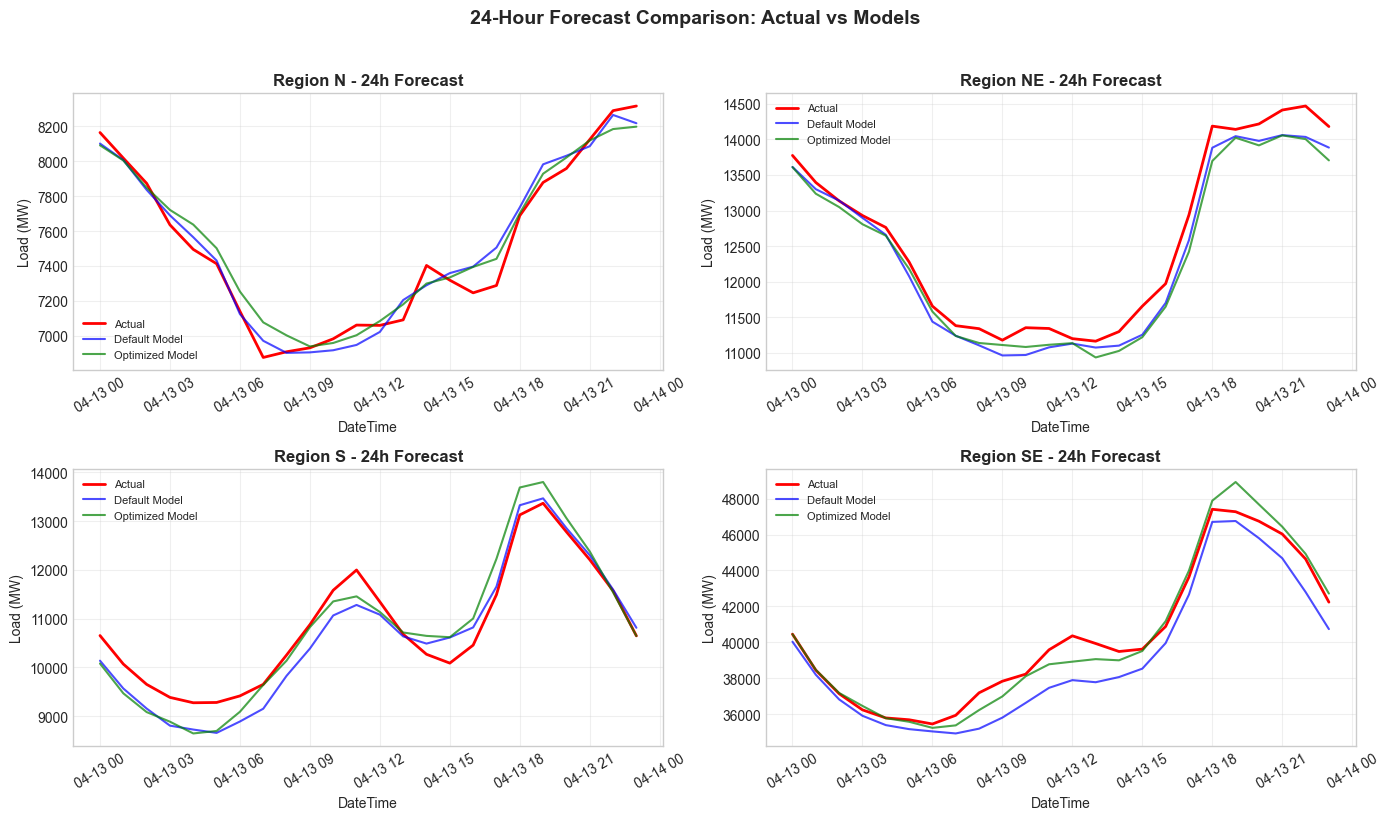

In [15]:
# Calculate MAE for 24-hour forecasts
mae_default_24h = {}
mae_optimized_24h = {}

print("=" * 60)
print("24-HOUR FORECAST EVALUATION - MAE Results")
print("=" * 60)

for region in regions:
    mae_default_24h[region], mae_optimized_24h[region] = calculate_mae(forecasts_24h[region])
    
    print(f"\nRegion {region}:")
    print(f"   Default Model MAE:   {mae_default_24h[region]:.2f} MW")
    print(f"   Optimized Model MAE: {mae_optimized_24h[region]:.2f} MW")
    
    # Determine winner
    if mae_default_24h[region] < mae_optimized_24h[region]:
        print(f"   Winner: Default Model")
    else:
        print(f"   Winner: Optimized Model")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, region in enumerate(regions):
    data = forecasts_24h[region]
    axes[i].plot(data['date'], data['total_load'], color='red', label='Actual', linewidth=2)
    axes[i].plot(data['date'], data['NBEATS'], color='blue', label='Default Model', linewidth=1.5, alpha=0.7)
    axes[i].plot(data['date'], data['NBEATS1'], color='green', label='Optimized Model', linewidth=1.5, alpha=0.7)
    axes[i].set_title(f'Region {region} - 24h Forecast', fontweight='bold')
    axes[i].set_xlabel('DateTime')
    axes[i].set_ylabel('Load (MW)')
    axes[i].legend(fontsize=8)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('24-Hour Forecast Comparison: Actual vs Models', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/forecast/24h_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 9.2 Save Best 24-Hour Models
Select and save the best performing model for each region based on MAE evaluation.

In [16]:
# Save best 24-hour models
print("=" * 60)
print("SAVING BEST 24-HOUR MODELS")
print("=" * 60)

for region in regions:
    region_df = df[df['region_id'] == region].drop(['region_name'], axis=1)
    
    # Select best model based on MAE
    if mae_default_24h[region] < mae_optimized_24h[region]:
        print(f"\n Region {region}: Saving Default Model (MAE: {mae_default_24h[region]:.2f})")
        best_params = models_24h[region].models[0].hparams
    else:
        print(f"\n Region {region}: Saving Optimized Model (MAE: {mae_optimized_24h[region]:.2f})")
        best_params = models_24h[region].models[1].hparams
    
    # Train final model on full data
    final_model = train_final_model(best_params, region_df)
    
    # Save model
    model_path = f'../models/NBEATS_{region}_24h_model.pkl'
    joblib.dump(final_model, model_path)
    print(f"   Saved: {model_path}")

print("\n" + "=" * 60)
print("ALL 24-HOUR MODELS SAVED SUCCESSFULLY")
print("=" * 60)

Seed set to 1


SAVING BEST 24-HOUR MODELS

 Region N: Saving Default Model (MAE: 68.18)
Epoch 2499: 100%|██████████| 1/1 [00:00<00:00, 19.51it/s, v_num=74, train_loss_step=120.0, train_loss_epoch=120.0] 
   Saved: ../models/NBEATS_N_24h_model.pkl

 Region NE: Saving Default Model (MAE: 215.04)


Seed set to 1


Epoch 2499: 100%|██████████| 1/1 [00:00<00:00, 19.09it/s, v_num=75, train_loss_step=213.0, train_loss_epoch=213.0] 


Seed set to 1


   Saved: ../models/NBEATS_NE_24h_model.pkl

 Region S: Saving Optimized Model (MAE: 360.51)
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 17.98it/s, v_num=76, train_loss_step=0.219, train_loss_epoch=0.219]
   Saved: ../models/NBEATS_S_24h_model.pkl

 Region SE: Saving Optimized Model (MAE: 488.14)


Seed set to 1


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 11.85it/s, v_num=77, train_loss_step=0.197, train_loss_epoch=0.197]
   Saved: ../models/NBEATS_SE_24h_model.pkl

ALL 24-HOUR MODELS SAVED SUCCESSFULLY


---
## 10. Train N-BEATS Models - 168-Hour Horizon (Weekly)

Train models for medium-term (168-hour / 1 week) electricity demand forecasting.

In [17]:
# 168-Hour Horizon Training
HORIZON_168 = 168
models_168h = {}
forecasts_168h = {}

print("=" * 60)
print("TRAINING N-BEATS MODELS - 168-HOUR HORIZON (WEEKLY)")
print("=" * 60)

for region in regions:
    print(f"\n{'='*40}")
    print(f"Training models for Region: {region}")
    print(f"{'='*40}")
    
    # Prepare data
    region_df = df[df['region_id'] == region].drop(['region_name'], axis=1)
    train_df, test_df = train_test_split(region_df, HORIZON_168)
    
    # Train models (using 24h params as fallback - ideally load 168h params)
    model = train_nbeats(train_df, region, HORIZON_168, best_params_24h)
    
    # Generate predictions
    preds = model.predict().reset_index()
    
    # Merge predictions with test data
    merged = pd.merge(test_df, preds, on=['region_id', 'date'], how='left')
    
    # Store results
    models_168h[region] = model
    forecasts_168h[region] = merged
    
    print(f"Completed training for region {region}")

print("\n" + "=" * 60)
print("ALL 168-HOUR MODELS TRAINED SUCCESSFULLY")
print("=" * 60)

Seed set to 1
Seed set to 1


TRAINING N-BEATS MODELS - 168-HOUR HORIZON (WEEKLY)

Training models for Region: N
Using accelerator: gpu
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 111.25it/s]

Seed set to 1
Seed set to 1



Completed training for region N

Training models for Region: NE
Using accelerator: gpu
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 83.12it/s]

Seed set to 1
Seed set to 1



Completed training for region NE

Training models for Region: S
Using accelerator: gpu
Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 86.06it/s] 

Seed set to 1



Completed training for region S

Training models for Region: SE
Using accelerator: gpu


Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 67.41it/s]
Completed training for region SE

ALL 168-HOUR MODELS TRAINED SUCCESSFULLY


### 10.1 Evaluate and Visualize 168-Hour Forecasts

168-HOUR FORECAST EVALUATION - MAE Results

 Region N:
   Default Model MAE:   243.79 MW
   Optimized Model MAE: 212.33 MW
   Winner: Optimized Model

 Region NE:
   Default Model MAE:   332.56 MW
   Optimized Model MAE: 426.50 MW
   Winner: Default Model

 Region S:
   Default Model MAE:   1602.18 MW
   Optimized Model MAE: 575.65 MW
   Winner: Optimized Model

 Region SE:
   Default Model MAE:   5992.30 MW
   Optimized Model MAE: 969.94 MW
   Winner: Optimized Model


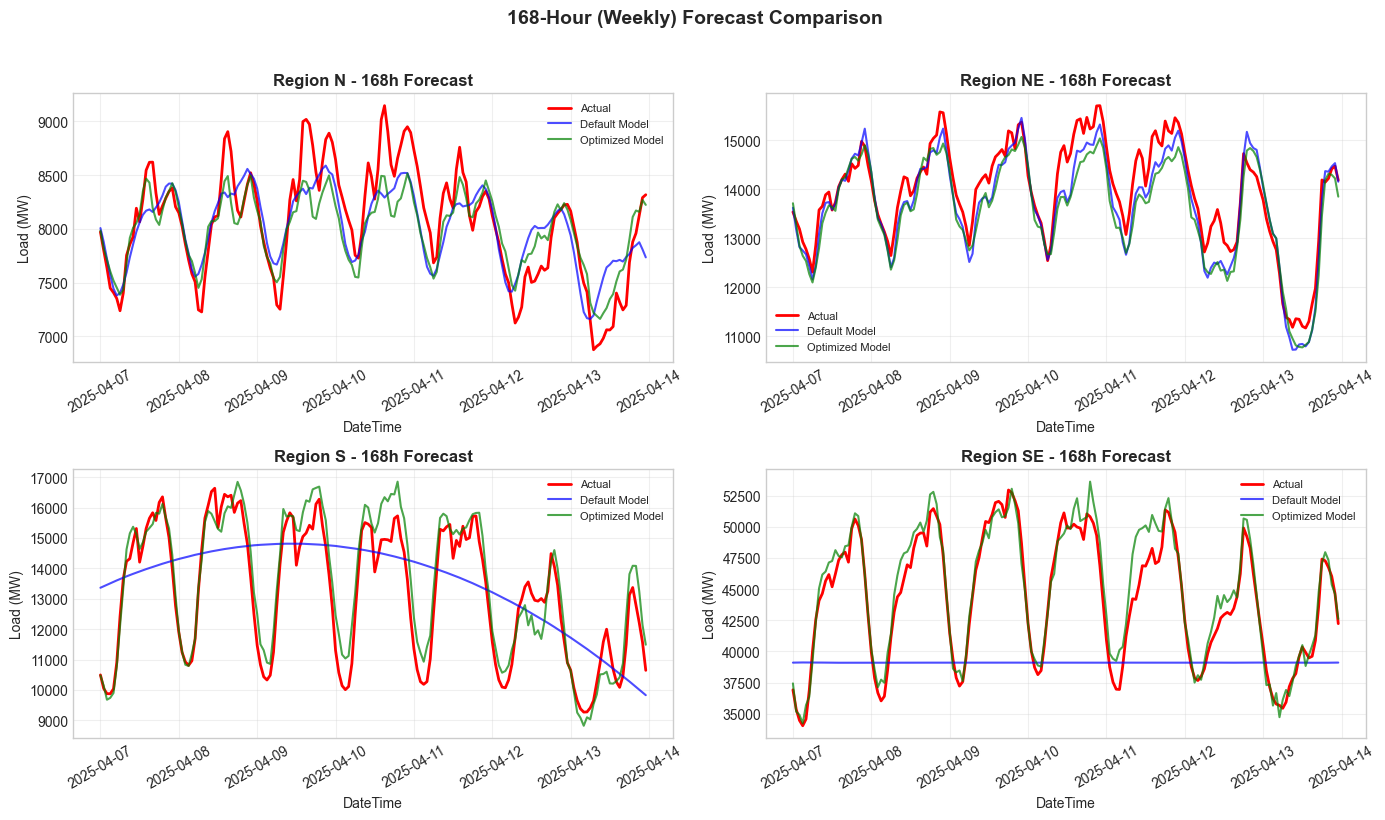

In [18]:
# Calculate MAE for 168-hour forecasts
mae_default_168h = {}
mae_optimized_168h = {}

print("=" * 60)
print("168-HOUR FORECAST EVALUATION - MAE Results")
print("=" * 60)

for region in regions:
    mae_default_168h[region], mae_optimized_168h[region] = calculate_mae(forecasts_168h[region])
    
    print(f"\n Region {region}:")
    print(f"   Default Model MAE:   {mae_default_168h[region]:.2f} MW")
    print(f"   Optimized Model MAE: {mae_optimized_168h[region]:.2f} MW")
    
    if mae_default_168h[region] < mae_optimized_168h[region]:
        print(f"   Winner: Default Model")
    else:
        print(f"   Winner: Optimized Model")

# Visualize forecasts
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()

for i, region in enumerate(regions):
    data = forecasts_168h[region]
    axes[i].plot(data['date'], data['total_load'], color='red', label='Actual', linewidth=2)
    axes[i].plot(data['date'], data['NBEATS'], color='blue', label='Default Model', linewidth=1.5, alpha=0.7)
    axes[i].plot(data['date'], data['NBEATS1'], color='green', label='Optimized Model', linewidth=1.5, alpha=0.7)
    axes[i].set_title(f'Region {region} - 168h Forecast', fontweight='bold')
    axes[i].set_xlabel('DateTime')
    axes[i].set_ylabel('Load (MW)')
    axes[i].legend(fontsize=8)
    axes[i].tick_params(axis='x', rotation=30)
    axes[i].grid(True, alpha=0.3)

plt.suptitle('168-Hour (Weekly) Forecast Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../images/forecast/168h_forecast_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

### 10.2 Save Best 168-Hour Models

In [19]:
# Save best 168-hour models
print("=" * 60)
print("SAVING BEST 168-HOUR MODELS")
print("=" * 60)

for region in regions:
    region_df = df[df['region_id'] == region].drop(['region_name'], axis=1)
    
    # Select best model based on MAE
    if mae_default_168h[region] < mae_optimized_168h[region]:
        print(f"\n Region {region}: Saving Default Model (MAE: {mae_default_168h[region]:.2f})")
        best_params = models_168h[region].models[0].hparams
    else:
        print(f"\n Region {region}: Saving Optimized Model (MAE: {mae_optimized_168h[region]:.2f})")
        best_params = models_168h[region].models[1].hparams
    
    # Train final model on full data
    final_model = train_final_model(best_params, region_df)
    
    # Save model
    model_path = f'../models/NBEATS_{region}_168h_model.pkl'
    joblib.dump(final_model, model_path)
    print(f"   Saved: {model_path}")

print("\n" + "=" * 60)
print(" ALL 168-HOUR MODELS SAVED SUCCESSFULLY")
print("=" * 60)

Seed set to 1


SAVING BEST 168-HOUR MODELS

 Region N: Saving Optimized Model (MAE: 212.33)
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 16.10it/s, v_num=94, train_loss_step=0.779, train_loss_epoch=0.779]
   Saved: ../models/NBEATS_N_168h_model.pkl

 Region NE: Saving Default Model (MAE: 332.56)


Seed set to 1


Epoch 2499: 100%|██████████| 1/1 [00:00<00:00, 17.83it/s, v_num=95, train_loss_step=819.0, train_loss_epoch=819.0]   


Seed set to 1


   Saved: ../models/NBEATS_NE_168h_model.pkl

 Region S: Saving Optimized Model (MAE: 575.65)
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 19.88it/s, v_num=96, train_loss_step=0.437, train_loss_epoch=0.437]
   Saved: ../models/NBEATS_S_168h_model.pkl

 Region SE: Saving Optimized Model (MAE: 969.94)


Seed set to 1


Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 11.65it/s, v_num=97, train_loss_step=0.447, train_loss_epoch=0.447]
   Saved: ../models/NBEATS_SE_168h_model.pkl

 ALL 168-HOUR MODELS SAVED SUCCESSFULLY


---
## 12. Results Summary

### Model Performance Comparison

In [20]:
# Create summary table
print("=" * 70)
print("FINAL RESULTS SUMMARY")
print("=" * 70)

# 24-Hour Results
print("\n 24-HOUR HORIZON RESULTS")
print("-" * 50)
results_24h = []
for region in regions:
    best_mae = min(mae_default_24h[region], mae_optimized_24h[region])
    best_model = "Default" if mae_default_24h[region] < mae_optimized_24h[region] else "Optimized"
    
    # Calculate normalized MAE
    min_val = forecasts_24h[region]['total_load'].min()
    max_val = forecasts_24h[region]['total_load'].max()
    normalized_mae = best_mae / (max_val - min_val)
    
    results_24h.append({
        'Region': region,
        'Best Model': best_model,
        'MAE (MW)': float(best_mae),
        'Normalized MAE': float(normalized_mae)
    })

df_results_24h = pd.DataFrame(results_24h)
print(df_results_24h.to_string(index=False))

# 168-Hour Results
print("\n 168-HOUR HORIZON RESULTS")
print("-" * 50)
results_168h = []
for region in regions:
    best_mae = min(mae_default_168h[region], mae_optimized_168h[region])
    best_model = "Default" if mae_default_168h[region] < mae_optimized_168h[region] else "Optimized"
    
    min_val = forecasts_168h[region]['total_load'].min()
    max_val = forecasts_168h[region]['total_load'].max()
    normalized_mae = best_mae / (max_val - min_val)
    
    results_168h.append({
        'Region': region,
        'Best Model': best_model,
        'MAE (MW)': float(best_mae),
        'Normalized MAE': float(normalized_mae)
    })

df_results_168h = pd.DataFrame(results_168h)
print(df_results_168h.to_string(index=False))

print("\n" + "=" * 70)


FINAL RESULTS SUMMARY

 24-HOUR HORIZON RESULTS
--------------------------------------------------
Region Best Model   MAE (MW)  Normalized MAE
     N    Default  68.179173        0.047296
    NE    Default 215.043894        0.065038
     S  Optimized 360.513986        0.088003
    SE  Optimized 488.137651        0.040799

 168-HOUR HORIZON RESULTS
--------------------------------------------------
Region Best Model   MAE (MW)  Normalized MAE
     N  Optimized 212.330215        0.093529
    NE    Default 332.555916        0.073240
     S  Optimized 575.650719        0.078196
    SE  Optimized 969.935215        0.051288



---
## Conclusions

### Key Findings:
1. **Seasonality**: Strong daily (24h) and weekly (168h) patterns observed across all regions
2. **Regional Differences**: Southeast (SE) region shows highest demand, followed by South (S)
3. **Model Performance**: N-BEATS effectively captures both trend and seasonal components
4. **Optimization**: Optuna-tuned hyperparameters generally improve forecast accuracy


---
*Notebook created for Brazil's National Interconnected System (SIN) electricity demand forecasting*